In [1]:
import sys
import sklearn
import numpy as np
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import pandas as pd
import matplotlib.image as mpimg

soccer_field = mpimg.imread('soccer-field.png')

In [2]:
# Assigning the data to variables

data = pd.read_json('events_England.json')
player_data = pd.read_json('players.json')

In [3]:
# Dropping columns from the player dataframe that seem unrelated to the current problem

player_data.drop(['passportArea', 'weight', 'firstName', 'middleName', 'lastName',
                  'currentTeamId', 'birthDate', 'height', 'birthArea', 'shortName', 'currentNationalTeamId'], axis=1, inplace=True)

In [4]:
# Simplifying the role of the players to more meaningful and easier-to-understand format

def simplify_role(role_dict):
    role_code = role_dict.get('code2')
    if role_code == 'DF':
        return 'defender'
    elif role_code == 'GK':
        return 'goalkeeper'
    elif role_code == 'MD':
        return 'midfield'
    elif role_code == 'FW':
        return 'forward'

player_data['simplified_role'] = player_data['role'].apply(simplify_role)
player_data.drop(['role'], axis=1, inplace=True)

In [5]:
# Since I am only interested in goals, only events that can lead to a goal are included i.e. shots

df = data[data['eventName'] == 'Shot']

In [6]:
# Renaming column playerID to wyId to make the two dataframes have a common column to for merging later

df.rename(columns={'playerId': 'wyId'}, inplace = True)

C:\Users\Juuse\AppData\Local\Temp\ipykernel_72072\1106045682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'playerId': 'wyId'}, inplace = True)


In [7]:
# Creating a new binary variable 'is_goal' from the original dataframe to tell if the shot lead to a goal or not

def check_for_101(tags_list):
    for tag in tags_list:
        if tag.get('id') == 101:
            return 1
    return 0

df.loc[:, 'is_goal'] = df['tags'].apply(lambda x: check_for_101(x))

C:\Users\Juuse\AppData\Local\Temp\ipykernel_72072\2498796145.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'is_goal'] = df['tags'].apply(lambda x: check_for_101(x))


In [8]:
def check_if_blocked(tags_list):
    for tag in tags_list:
        if tag.get('id') == 2101:
            return 1
    return 0

df.loc[:, 'is_goal'] = df['tags'].apply(lambda x: check_for_101(x))

In [9]:
# Mapping how the shot was taken. This is later used for determine if the shot was taken with the stronger foot

def shot_with(tags_list):
    for tag in tags_list:
        if tag.get('id') == 401:
            return 'left'
        elif tag.get('id') == 402:
            return 'right'
        elif tag.get('id') == 403:
            return 'head/body'
        
df.loc[:, 'shot_with'] = df['tags'].apply(lambda x: shot_with(x))

C:\Users\Juuse\AppData\Local\Temp\ipykernel_72072\1606505028.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'shot_with'] = df['tags'].apply(lambda x: shot_with(x))


In [10]:
# Merging the two dataframes together via wyID column

merged_df = df.merge(player_data, on='wyId', how='inner')

In [11]:
# We drop unnecessary columns such as Ids and time related features and only focus on player attributes and location

merged_df.drop(['eventId', 'subEventName', 'wyId', 'matchId', 'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id'], axis=1, inplace=True)


In [12]:
# Then we add a new column 'preferred_foot' to tell us if the player shot with his weak foot or if he headed it

for index, row in merged_df.iterrows():
    if row['shot_with'] == row['foot']:
        merged_df.loc[index, 'preferred_foot'] = 1
    else:
        merged_df.loc[index, 'preferred_foot'] = 0

In [13]:
# Then we use LabelEncoder() to transform 'simplified_role' and 'shot_with'to integer values
#     Defender: 1
#     Forward: 2
#     Midfield: 3

#     Head: 1
#     left: 2
#     right: 3

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
merged_df['simplified_role'] = encoder.fit_transform(merged_df['simplified_role'])
merged_df['shot_with'] = encoder.fit_transform(merged_df['shot_with'])
constant_value = 1
merged_df['simplified_role'] += constant_value
merged_df['shot_with'] += constant_value

In [14]:
# I can then drop the columns about foot and tags.

merged_df.drop(['tags', 'foot'], axis=1, inplace=True)


In [15]:
# Then I can separate the position values and just leave the origin coordinates to their respective columns and drop the positions column

for index, row in merged_df.iterrows(): 
    merged_df.loc[index, 'x'] = row['positions'][0]['x']
    merged_df.loc[index, 'y'] = row['positions'][0]['y']

merged_df.drop(['positions'], axis=1, inplace=True)

In [16]:
# I calculate the 'shot_angle' and 'shot_distance' as our features

import math

goal_post_coordinates = {'x1': 100, 'y1': 37, 'x2': 100, 'y2': 63}
central_goal_line = {'x': 100, 'y': 50}

def calculate_shot_angle(x, y, goal_post_coordinates):
    x1 = goal_post_coordinates['x1']
    y1 = goal_post_coordinates['y1']
    x2 = goal_post_coordinates['x2']
    y2 = goal_post_coordinates['y2']
    
    angle = math.degrees(math.atan2(y - y1, x - x1) - math.atan2(y2 - y1, x2 - x1))
    
    # Normalize the angle to be in the range [0, 360)
    angle = (angle + 360) % 360
    
    return angle

merged_df['shot_angle'] = merged_df.apply(lambda row: calculate_shot_angle(row['x'], row['y'], goal_post_coordinates), axis=1)

def calculate_shot_distance(row):
    shot_x = row['x']
    shot_y = row['y']
    
    horizontal_distance = abs(shot_x - central_goal_line['x'])
    vertical_distance = abs(shot_y - central_goal_line['y'])
    
    shot_distance = math.sqrt(horizontal_distance ** 2 + vertical_distance ** 2)
    
    return shot_distance

merged_df['shot_distance'] = merged_df.apply(calculate_shot_distance, axis=1)

<AxesSubplot:>

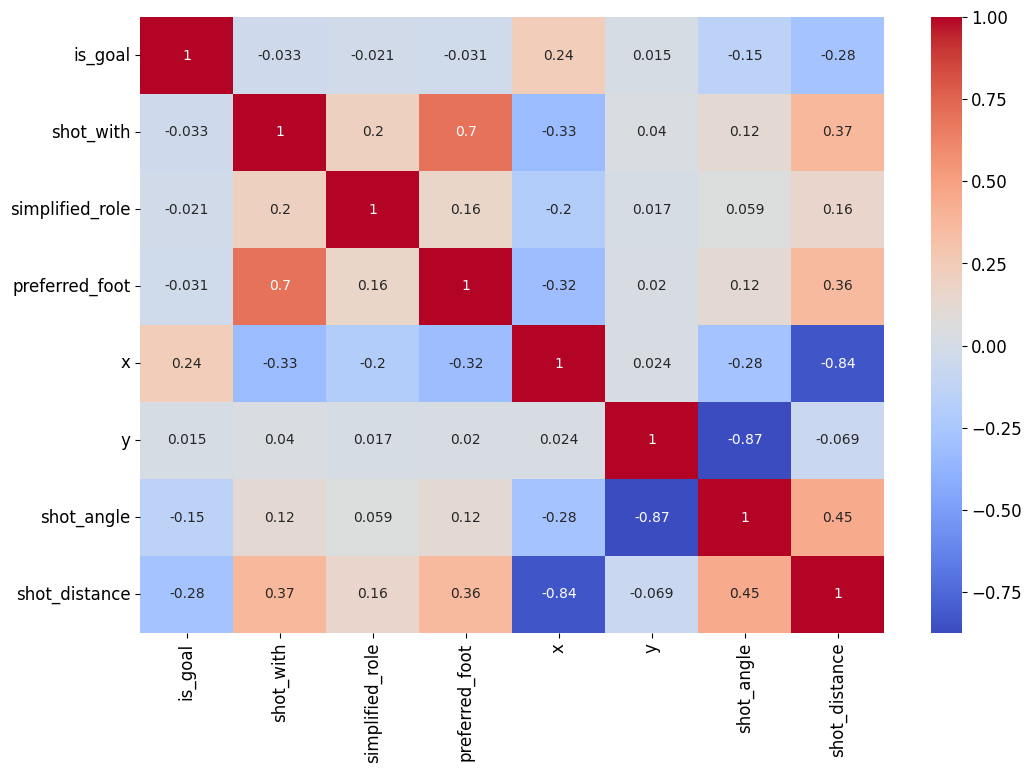

In [17]:
# Simple correlation matrix to examine if there are any notable correlations between label and features

import seaborn as sns

corr_matrix = merged_df.corr()
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

C:\Users\Juuse\AppData\Local\Temp\ipykernel_72072\2977691135.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='is_goal', palette=colors)
C:\Users\Juuse\AppData\Local\Temp\ipykernel_72072\2977691135.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(data=merged_df, x='is_goal', palette=colors)


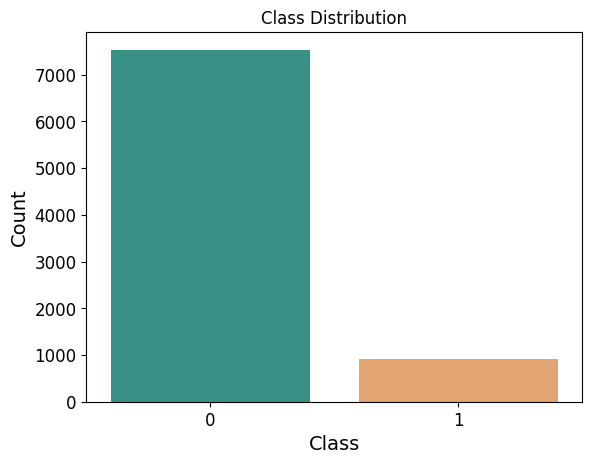

In [18]:
# We check how the values are distributed between the two classes.

colors = ['#2a9d8f', '#f4a261', '#e76f51']
sns.countplot(data=merged_df, x='is_goal', palette=colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [19]:
# Splitting the data into label and features and constructing three datasets: training, validation and test.

X = merged_df[['shot_with', 'simplified_role', 'preferred_foot', 'x', 'y', 'shot_angle', 'shot_distance']]
y = merged_df[['is_goal']]

from sklearn.model_selection import train_test_split

X_train, X_comb, y_train, y_comb = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_comb, y_comb, test_size=0.5, random_state=42)

In [20]:
# The class 0 (no goal) is very much overrepresented in the data (data is unbalanced) so we use SMOTE to balance the training data. This way I hope the model learns to predict the goals a bit better
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train, y_train)
y_sm_2 = np.array(y_sm)
y_sm_2 = y_sm_2.reshape(10608,)


In [21]:
# Building the first model. SVC is known for good prediction power in binary classification problems and works well with kind of smaller datasets.
# I fit the SMOTE-balanced data into the model and make predictions with validation features.

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

clf = make_pipeline(StandardScaler(), SVC(kernel='poly', C=1, degree=2, gamma='auto', probability=True))
clf.fit(X_sm, y_sm_2)
y_pred_clf = clf.predict(X_val)
print(classification_report(y_val, y_pred_clf))

              precision    recall  f1-score   support

           0       0.92      0.73      0.82      1097
           1       0.26      0.59      0.36       170

    accuracy                           0.72      1267
   macro avg       0.59      0.66      0.59      1267
weighted avg       0.83      0.72      0.76      1267



In [22]:
# I use the build-in method in sklearn's SVC model to extract the probabilities for the individual predictions. After I create an array with only the probabilities for goals and mark it as xG.

predicted_probabilities_clf_val = clf.predict_proba(X_val)
goal_probabilities_clf_val = predicted_probabilities_clf_val[:, 1]

xG_per_datapoint_clf_val = []

for probability in goal_probabilities_clf_val:
    xG_per_datapoint_clf_val.append(probability)

In [23]:
# Model then gets to see the test data for the first time and uses it to make predictions.

y_pred_test_clf = clf.predict(X_test)
print(classification_report(y_test, y_pred_test_clf))

              precision    recall  f1-score   support

           0       0.94      0.74      0.83      1135
           1       0.21      0.59      0.31       133

    accuracy                           0.72      1268
   macro avg       0.57      0.66      0.57      1268
weighted avg       0.86      0.72      0.77      1268



C:\Users\Juuse\AppData\Local\Temp\ipykernel_72072\2406617190.py:25: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  plt.imshow(xG_values.T, extent=[0, field_width, 50, 102], origin='lower', alpha=0.4)


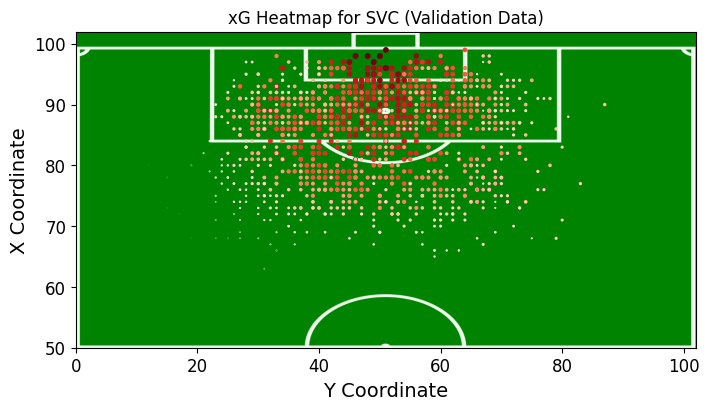

In [24]:
# Creating a visualisation to emphasize how the probabilities are scattered around the goal.
from matplotlib.cm import ScalarMappable

background_image = mpimg.imread('soccer-field.png')

xG_values = np.array(xG_per_datapoint_clf_val) 
xG_values = xG_values.reshape(1267, 1)
x_coordinates = []  
y_coordinates = []  

for index, row in X_val.iterrows():
    x_coordinates.append(row['x'])
    y_coordinates.append(row['y'])

field_length = 100
field_width = 0

grid_resolution = 1  
x_values = np.arange(0, field_width + grid_resolution, grid_resolution)
y_values = np.arange(0, field_length + grid_resolution, grid_resolution)  
X, Y = np.meshgrid(x_values, y_values) 

plt.figure(figsize=(8, 5)) 

plt.imshow(xG_values.T, extent=[0, field_width, 50, 102], origin='lower', alpha=0.4) 

plt.scatter(y_coordinates, x_coordinates, c=xG_values, cmap='Reds', s=10 * xG_values, edgecolor=None) 
# Overlay the background image, swapping extent values
plt.imshow(background_image, extent=[0, 102, 50, 102])


plt.xlabel('Y Coordinate')  
plt.ylabel('X Coordinate')  
sm = ScalarMappable(cmap='Reds')
sm.set_array([])

plt.title('xG Heatmap for SVC (Validation Data)')
plt.show()

In [25]:
# Listing some metrics to further evaluate the performance of the model (with validation data). Mean squared error = 1 - accuracy since with binary task mean squared error is essenitally the same as 0/1-error
# Metrics are tested with different probability thresholds to test how it affects the metrics

from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, accuracy_score

# Get the predicted probabilities for class 1 (positive class)
predicted_probabilities_clf_lower = clf.predict_proba(X_val)[:, 1]

# Define the new threshold
new_threshold = 0.7

# Adjust predictions based on the new threshold
y_pred_adjusted_clf = (predicted_probabilities_clf_lower >= new_threshold).astype(int)

accuracy_adjusted_clf_val = accuracy_score(y_val, y_pred_adjusted_clf)
recall_adjusted_clf_val = recall_score(y_val, y_pred_adjusted_clf)
precision_adjusted_clf_val = precision_score(y_val, y_pred_adjusted_clf)
f1_adjusted_clf_val = f1_score(y_val, y_pred_adjusted_clf)

print(f"SVC Validation score with threshold {new_threshold}")
print(f"Precision: {precision_adjusted_clf_val}")
print(f"Recall: {recall_adjusted_clf_val}")

print(f"F1-score: {f1_adjusted_clf_val}")
print(f"Acc: {accuracy_adjusted_clf_val}")
print(f"Error: {mean_squared_error(y_val, y_pred_adjusted_clf)}")

SVC Validation score with threshold 0.7
Precision: 0.40540540540540543
Recall: 0.35294117647058826
F1-score: 0.37735849056603776
Acc: 0.8437253354380426
Error: 0.15627466456195738


In [26]:
# Same predict probabilities as with validation data

predicted_probabilities_clf_test = clf.predict_proba(X_test)
goal_probabilities_clf_test = predicted_probabilities_clf_test[:, 1]

# Initialize an empty list to store xG for each data point
xG_per_datapoint_clf_test = []

# Iterate through each data point and calculate xG
for probability in goal_probabilities_clf_test:
    xG_per_datapoint_clf_test.append(probability)


In [27]:
# Doing the same process as above, but with test data.

# Get the predicted probabilities for class 1 (positive class)
predicted_probabilities_clf_lower_test = clf.predict_proba(X_test)[:, 1]

# Define the new threshold
new_threshold = 0.7

# Adjust predictions based on the new threshold
y_pred_adjusted_clf_test = (predicted_probabilities_clf_lower_test >= new_threshold).astype(int)

accuracy_adjusted_clf_test = accuracy_score(y_test, y_pred_adjusted_clf_test)
recall_adjusted_clf_test = recall_score(y_test, y_pred_adjusted_clf_test)
precision_adjusted_clf_test = precision_score(y_test, y_pred_adjusted_clf_test)
f1_adjusted_clf_test = f1_score(y_test, y_pred_adjusted_clf_test)

print(f"SVC Validation score with threshold {new_threshold}")
print(f"Precision: {precision_adjusted_clf_test}")
print(f"Recall: {recall_adjusted_clf_test}")

print(f"F1-score: {f1_adjusted_clf_test}")
print(f"Acc: {accuracy_adjusted_clf_test}")
print(f"Error: {mean_squared_error(y_test, y_pred_adjusted_clf_test)}")


SVC Validation score with threshold 0.7
Precision: 0.31654676258992803
Recall: 0.3308270676691729
F1-score: 0.32352941176470584
Acc: 0.8548895899053628
Error: 0.14511041009463724


C:\Users\Juuse\AppData\Local\Temp\ipykernel_72072\564014123.py:25: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  plt.imshow(xG_values.T, extent=[0, field_width, 50, 102], origin='lower', alpha=0.4)


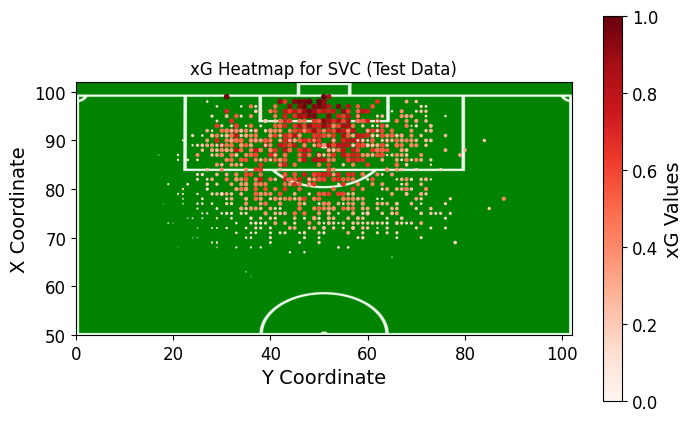

In [28]:
# Creating same kind of scatterplot visualisation as earlier but now with test data.

from matplotlib.cm import ScalarMappable
background_image = mpimg.imread('soccer-field.png')

xG_values = np.array(xG_per_datapoint_clf_test) 
xG_values = xG_values.reshape(1268, 1)
x_coordinates = []  
y_coordinates = []  

for index, row in X_test.iterrows():
    x_coordinates.append(row['x'])
    y_coordinates.append(row['y'])

field_length = 100
field_width = 0

grid_resolution = 1  
x_values = np.arange(0, field_width + grid_resolution, grid_resolution)
y_values = np.arange(0, field_length + grid_resolution, grid_resolution) 
X, Y = np.meshgrid(x_values, y_values) 

plt.figure(figsize=(8, 5))  

plt.imshow(xG_values.T, extent=[0, field_width, 50, 102], origin='lower', alpha=0.4) 

plt.scatter(y_coordinates, x_coordinates, c=xG_values, cmap='Reds', s=10 * xG_values, edgecolor=None) 

plt.imshow(background_image, extent=[0, 102, 50, 102]) 

plt.xlabel('Y Coordinate')  
plt.ylabel('X Coordinate')  
sm = ScalarMappable(cmap='Reds')
sm.set_array([])  

colorbar = plt.colorbar(sm, label='xG Values')

plt.title('xG Heatmap for SVC (Test Data)')
plt.show()

In [29]:
# Second model is Random Forest. Random Forest usually works well with unbalanced data such as this, and might be appropriate choice. Again model is trained with SMOTE-balanced data first.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=13,
                            min_samples_leaf=2,
                            min_samples_split=3,
                            n_estimators=50,
                            oob_score=True)

y_sm_2 = np.array(y_sm)
y_sm_2 = y_sm_2.reshape(10608,)


rf.fit(X_sm, y_sm_2)
y_pred_rf_val = rf.predict(X_val)
print(classification_report(y_val, y_pred_rf_val))


              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1097
           1       0.29      0.32      0.30       170

    accuracy                           0.80      1267
   macro avg       0.59      0.60      0.59      1267
weighted avg       0.81      0.80      0.81      1267



In [30]:
# Same as with SVC. Trying different probability thresholds and examining the performance metrics

# Get the predicted probabilities for class 1 (positive class)
predicted_probabilities_rf_lower = rf.predict_proba(X_val)[:, 1]

# Define the new threshold
new_threshold = 0.7

# Adjust predictions based on the new threshold
y_pred_adjusted_rf_val = (predicted_probabilities_rf_lower >= new_threshold).astype(int)

accuracy_adjusted_rf_val = accuracy_score(y_val, y_pred_adjusted_rf_val)
recall_adjusted_rf_val = recall_score(y_val, y_pred_adjusted_rf_val)
precision_adjusted_rf_val = precision_score(y_val, y_pred_adjusted_rf_val)
f1_adjusted_rf_val = f1_score(y_val, y_pred_adjusted_rf_val)

print(f"SVC Validation score with threshold {new_threshold}")
print(f"Precision: {precision_adjusted_rf_val}")
print(f"Recall: {recall_adjusted_rf_val}")

print(f"F1-score: {f1_adjusted_rf_val}")
print(f"Acc: {accuracy_adjusted_rf_val}")
print(f"Error: {1 - accuracy_adjusted_rf_val}")

SVC Validation score with threshold 0.7
Precision: 0.2857142857142857
Recall: 0.10588235294117647
F1-score: 0.15450643776824033
Acc: 0.8445146014206788
Error: 0.1554853985793212


In [31]:
# Again, using a sklearn's Random Forest model's built-in function to extract predict probabilities.

predicted_probabilities_rf_val = rf.predict_proba(X_val)
goal_probabilities_rf_val = predicted_probabilities_rf_val[:, 1]

# Initialize an empty list to store xG for each data point
xG_per_datapoint_rf_val = []

# Iterate through each data point and calculate xG
for probability in goal_probabilities_rf_val:
    xG_per_datapoint_rf_val.append(probability)

C:\Users\Juuse\AppData\Local\Temp\ipykernel_72072\2088288265.py:32: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  plt.imshow(xG_values.T, extent=[0, field_width, 50, 102], origin='lower', alpha=0.4)  # Swap extent


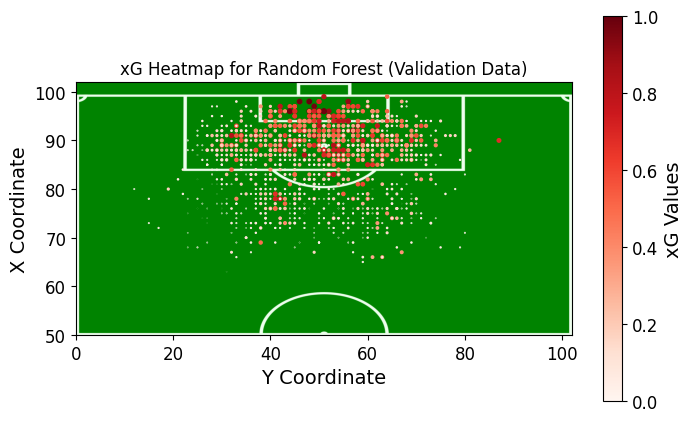

In [32]:
# Visualisation for Random Forest how the xG values are scattered on the field.

from matplotlib.cm import ScalarMappable

# Load your background image
background_image = mpimg.imread('soccer-field.png')

# Assuming you have xG values, x coordinates, and y coordinates for each data point
xG_values = np.array(xG_per_datapoint_rf_val)  # Replace with your list of xG values
xG_values = xG_values.reshape(1267, 1)
x_coordinates = []  # Replace with your list of x coordinates
y_coordinates = []  # Replace with your list of y coordinates

for index, row in X_val.iterrows():
    x_coordinates.append(row['x'])
    y_coordinates.append(row['y'])

# Define the dimensions of your field
field_length = 100
field_width = 0

# Create a heatmap grid
grid_resolution = 1  # 1 meter grid resolution
x_values = np.arange(0, field_width + grid_resolution, grid_resolution)
y_values = np.arange(0, field_length + grid_resolution, grid_resolution)  # Swap x and y values
X, Y = np.meshgrid(x_values, y_values)  # Swap X and Y

# Create a heatmap of xG values
plt.figure(figsize=(8, 5))  # Adjust figure size as needed

# Swap the extent and origin
plt.imshow(xG_values.T, extent=[0, field_width, 50, 102], origin='lower', alpha=0.4)  # Swap extent

# Plot each data point with a marker, swapping x and y coordinates
plt.scatter(y_coordinates, x_coordinates, c=xG_values, cmap='Reds', s=10 * xG_values, edgecolor=None)  # Swap coordinates

# Overlay the background image, swapping extent values
plt.imshow(background_image, extent=[0, 102, 50, 102])  # Swap extent

# Add labels and color bar (optional)
plt.xlabel('Y Coordinate')  # Swap X and Y labels
plt.ylabel('X Coordinate')  # Swap X and Y labels
sm = ScalarMappable(cmap='Reds')
sm.set_array([])  # Set an empty array to match the colormap with the data

# Add a colorbar to show the mapping of values to colors
colorbar = plt.colorbar(sm, label='xG Values')


# Show the plot
plt.title('xG Heatmap for Random Forest (Validation Data)')
#plt.savefig('rf_val_heatmap.png')
plt.show()

In [33]:
# Quick look at what features are most important for Random Forest's predictions.

feature_importances = rf.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = [X_train.columns[i] for i in sorted_indices]

for feature_name, importance in zip(sorted_feature_names, sorted_feature_importances):
    print(f"{feature_name}: {importance:.4f}")

shot_distance: 0.2514
x: 0.1846
shot_angle: 0.1511
y: 0.1443
preferred_foot: 0.1336
simplified_role: 0.0866
shot_with: 0.0484


In [34]:
# Making predictions with Random Forest using test dataset

y_preds_test_rf = rf.predict(X_test)

In [35]:
# Same pattern as before, getting the metrics with different thresholds

from sklearn.metrics import precision_score, recall_score, f1_score

# Get the predicted probabilities for class 1 (positive class)
predicted_probabilities_rf_lower_test = rf.predict_proba(X_test)[:, 1]

# Define the new threshold
new_threshold = 0.7

# Adjust predictions based on the new threshold
y_pred_adjusted_rf_test = (predicted_probabilities_rf_lower_test >= new_threshold).astype(int)

accuracy_adjusted_rf_test = accuracy_score(y_test, y_pred_adjusted_rf_test)
recall_adjusted_rf_test = recall_score(y_test, y_pred_adjusted_rf_test)
precision_adjusted_rf_test = precision_score(y_test, y_pred_adjusted_rf_test)
f1_adjusted_rf_test = f1_score(y_test, y_pred_adjusted_rf_test)

print(f"RF test score with threshold {new_threshold}")
print(f"Precision: {precision_adjusted_rf_test}")
print(f"Recall: {recall_adjusted_rf_test}")

print(f"F1-score: {f1_adjusted_rf_test}")
print(f"Acc: {accuracy_adjusted_rf_test}")
print(f"Error: {1 - accuracy_adjusted_rf_test}")

RF test score with threshold 0.7
Precision: 0.2753623188405797
Recall: 0.14285714285714285
F1-score: 0.18811881188118812
Acc: 0.8706624605678234
Error: 0.12933753943217663


In [36]:
# Familiar probability extraction from the model

predicted_probabilities_rf_test = rf.predict_proba(X_test)
goal_probabilities_rf_test = predicted_probabilities_rf_test[:, 1]

# Initialize an empty list to store xG for each data point
xG_per_datapoint_rf_test = []

# Iterate through each data point and calculate xG
for probability in goal_probabilities_rf_test:
    xG_per_datapoint_rf_test.append(probability)

C:\Users\Juuse\AppData\Local\Temp\ipykernel_72072\3734497563.py:30: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  plt.imshow(xG_values.T, extent=[0, field_width, 50, 102], origin='lower', alpha=0.4)  # Swap extent


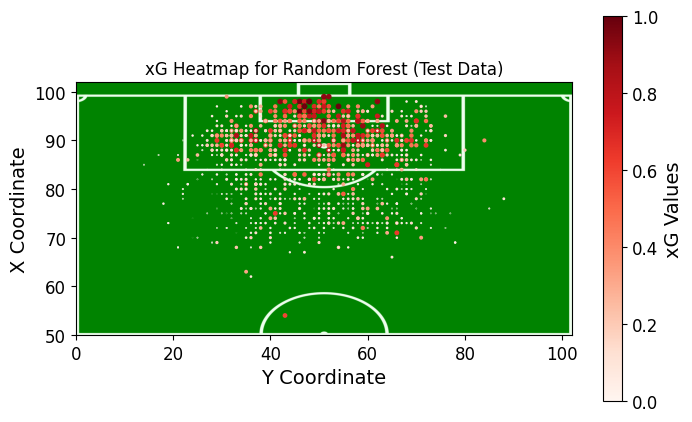

In [37]:
# Visualisation with test data

# Load your background image
background_image = mpimg.imread('soccer-field.png')

# Assuming you have xG values, x coordinates, and y coordinates for each data point
xG_values = np.array(xG_per_datapoint_rf_test)  # Replace with your list of xG values
xG_values = xG_values.reshape(1268, 1)
x_coordinates = []  # Replace with your list of x coordinates
y_coordinates = []  # Replace with your list of y coordinates

for index, row in X_test.iterrows():
    x_coordinates.append(row['x'])
    y_coordinates.append(row['y'])

# Define the dimensions of your field
field_length = 100
field_width = 0

# Create a heatmap grid
grid_resolution = 1  # 1 meter grid resolution
x_values = np.arange(0, field_width + grid_resolution, grid_resolution)
y_values = np.arange(0, field_length + grid_resolution, grid_resolution)  # Swap x and y values
X, Y = np.meshgrid(x_values, y_values)  # Swap X and Y

# Create a heatmap of xG values
plt.figure(figsize=(8, 5))  # Adjust figure size as needed

# Swap the extent and origin
plt.imshow(xG_values.T, extent=[0, field_width, 50, 102], origin='lower', alpha=0.4)  # Swap extent

# Plot each data point with a marker, swapping x and y coordinates
plt.scatter(y_coordinates, x_coordinates, c=xG_values, cmap='Reds', s=10 * xG_values, edgecolor=None)

# Overlay the background image, swapping extent values
plt.imshow(background_image, extent=[0, 102, 50, 102])  # Swap extent

# Add labels and color bar (optional)
plt.xlabel('Y Coordinate')  # Swap X and Y labels
plt.ylabel('X Coordinate')  # Swap X and Y labels
sm = ScalarMappable(cmap='Reds')
sm.set_array([])  # Set an empty array to match the colormap with the data

# Add a colorbar to show the mapping of values to colors
colorbar = plt.colorbar(sm, label='xG Values')

# Show the plot
plt.title('xG Heatmap for Random Forest (Test Data)')
plt.savefig('rf_test_heatmap.png')
plt.show()

In [38]:
# Calculating AUC scores for ROC/AUC curve for performance evaluation purposes

from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, goal_probabilities_rf_test)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print("AUC Score on Random Forest (Test): " + str(roc_auc_rf))

fpr_rf_val, tpr_rf_val, thresholds_rf_val = roc_curve(y_val, goal_probabilities_rf_val)
roc_auc_rf_val = auc(fpr_rf_val, tpr_rf_val)
print("AUC Score on Random Forest (Validation): " + str(roc_auc_rf_val))

fpr_clf_val, tpr_clf_val, thresholds_clf_val = roc_curve(y_val, goal_probabilities_clf_val)
roc_auc_clf_val = auc(fpr_clf_val, tpr_clf_val)
print("AUC Score on SVC (Validation): " + str(roc_auc_clf_val))

fpr_clf_test, tpr_clf_test, thresholds_clf_test = roc_curve(y_test, goal_probabilities_clf_test)
roc_auc_clf_test = auc(fpr_clf_test, tpr_clf_test)
print("AUC Score on SVC (Test): " + str(roc_auc_clf_test))

AUC Score on Random Forest (Test): 0.7119207710907224
AUC Score on Random Forest (Validation): 0.7044989007453484
AUC Score on SVC (Validation): 0.7258003110086332
AUC Score on SVC (Test): 0.7151634593090656


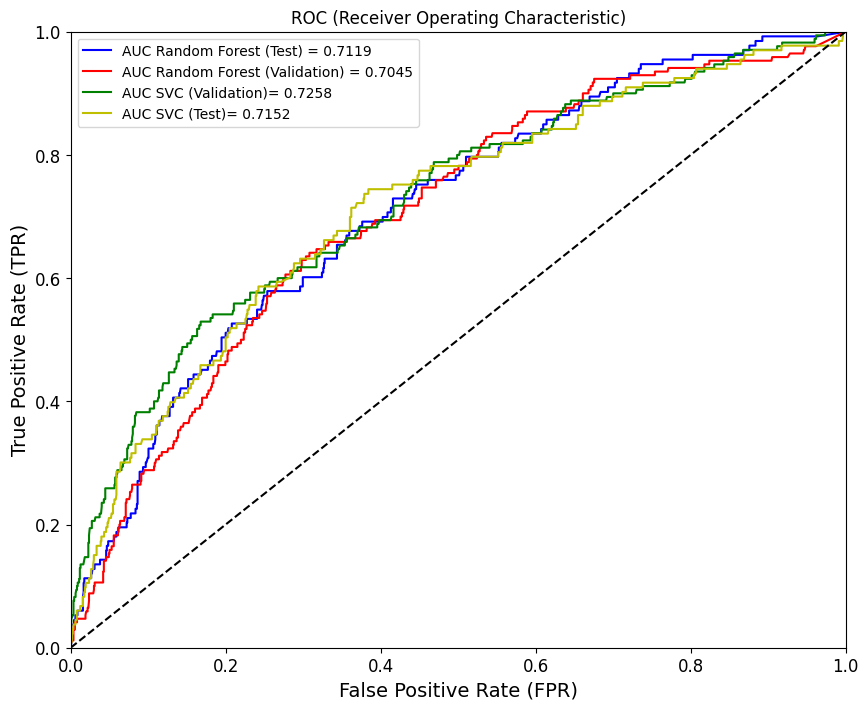

In [39]:
# Plotting the ROC/AUC curve

fig, axs =plt.subplots(1,1, figsize=(10,8))
plt.title('ROC (Receiver Operating Characteristic)')

plt.plot(fpr_rf, tpr_rf, 'b', label='AUC Random Forest (Test) = %0.4f'% roc_auc_rf)
plt.plot(fpr_rf_val, tpr_rf_val, 'r', label='AUC Random Forest (Validation) = %0.4f' % roc_auc_rf_val)
plt.plot(fpr_clf_val, tpr_clf_val, 'g', label='AUC SVC (Validation)= %0.4f'% roc_auc_clf_val)
plt.plot(fpr_clf_test, tpr_clf_test, 'y', label='AUC SVC (Test)= %0.4f'% roc_auc_clf_test)

plt.legend(loc='best')
plt.plot([0,1],[0,1],color='black', linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.savefig('roccurve.png')

In [40]:
# Building a confusion matrix function for evaluation purposes

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

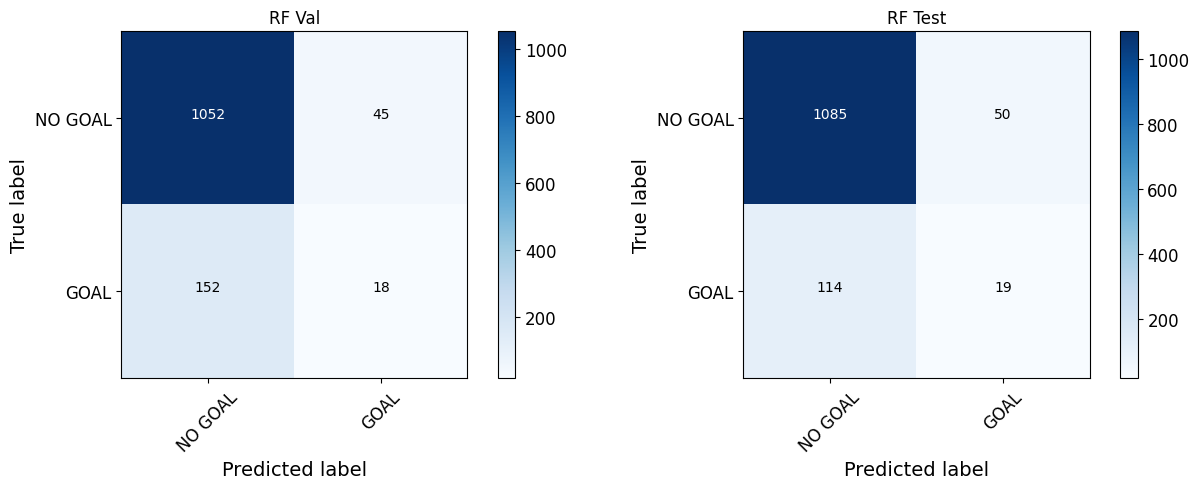

In [41]:
# Confusion matrix for Random Forest using validation and test data. The predictions correspond to the changes in the threshold that can be changed in earlier cells.

from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix_rf_val = confusion_matrix(y_val, y_pred_adjusted_rf_val)
cnf_matrix_rf_test = confusion_matrix(y_test, y_pred_adjusted_rf_test)
class_names = ['NO GOAL', 'GOAL']

plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_rf_val, classes=class_names,
                      title='RF Val')

plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_rf_test, classes=class_names,
                      title='RF Test')



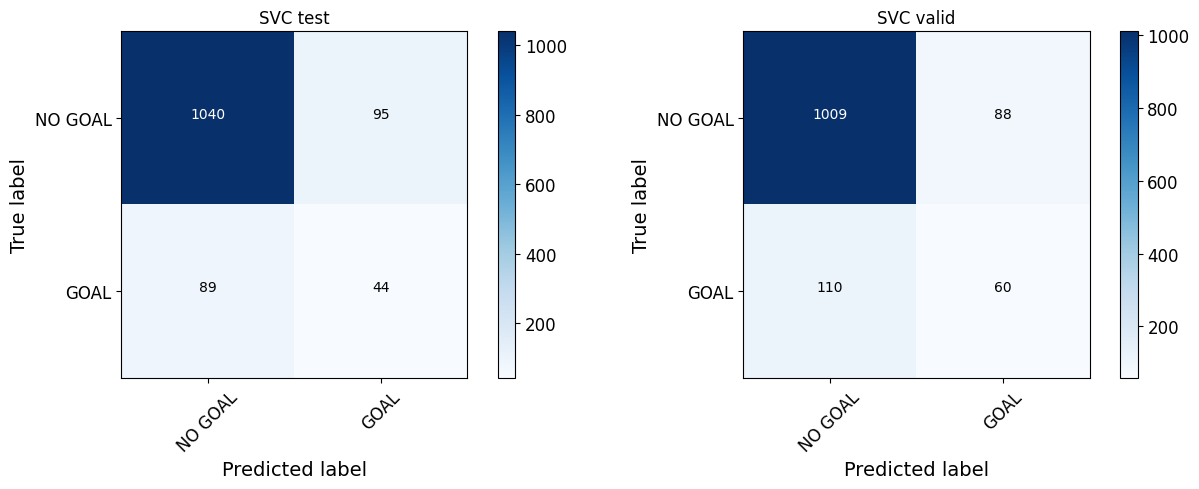

In [42]:
# Confusion matrix for SVC using validation and test data. The predictions correspond to the changes in the threshold that can be changed in earlier cells.

from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix_clf = confusion_matrix(y_test, y_pred_adjusted_clf_test)
cnf_matrix_clf_adjusted = confusion_matrix(y_val, y_pred_adjusted_clf)
class_names = ['NO GOAL', 'GOAL']

plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_clf, classes=class_names,
                      title='SVC test')

#plt.subplot(122) 
#plot_confusion_matrix(cnf_matrix_rf_nb, classes=class_names, normalize=True,
 #                     title='Normalized confusion matrix')

plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_clf_adjusted, classes=class_names,
                      title='SVC valid')

In [43]:
# Calculating the average probabilities of goals and not goals.

goals_rf = []
not_goals_rf = []
for i in goal_probabilities_rf_val:
    if i >= 0.50:
        goals_rf.append(i)
    else:
        not_goals_rf.append(i)

goals_clf = []
not_goals_clf = []
for i in goal_probabilities_clf_val:
    if i >= 0.50:
        goals_clf.append(i)
    else:
        not_goals_clf.append(i)
print(f"Mean value: {np.mean(not_goals_clf)}")
print(f"Mean value: {np.mean(not_goals_rf)}")
print(f"Mean value {np.mean(goal_probabilities_clf_val)}")
print(f"Mean value {np.mean(goal_probabilities_rf_val)}")


Mean value: 0.26144875066966683
Mean value: 0.14817252353061108
Mean value 0.393336519477496
Mean value 0.2249522650038213


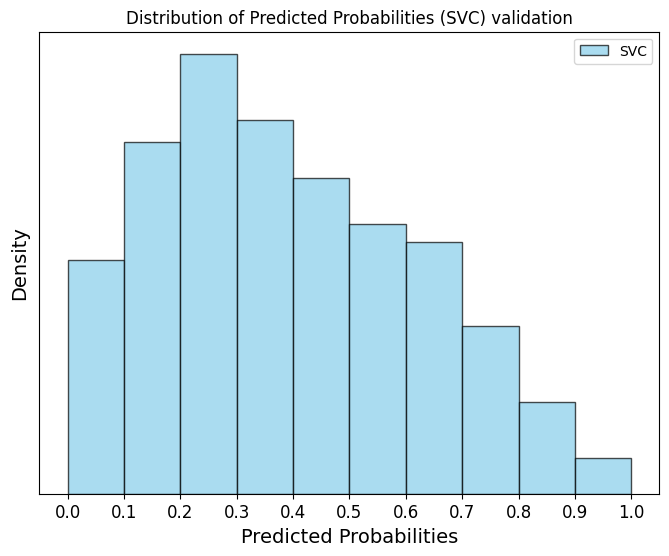

In [44]:
# Plotting a histogram to see how the probabilities are distributed in the case of SVC (validation data) to better understand what kind of predictions the model makes

import matplotlib.pyplot as plt
import numpy as np

# Define custom bin edges
num_bins = 10
custom_bin_edges = np.linspace(0, 1, num_bins + 1)

plt.figure(figsize=(8, 6))

# Use custom bin edges
plt.hist(goal_probabilities_clf_val, bins=custom_bin_edges, density=True, color='skyblue', alpha=0.7, edgecolor='black')

# Add labels and a title
plt.xlabel('Predicted Probabilities')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities (SVC) validation')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks([])  # Hide y-axis tick marks

#plt.savefig('SVC_prob_density.png')
plt.legend(['SVC'], loc='upper right')

plt.show()

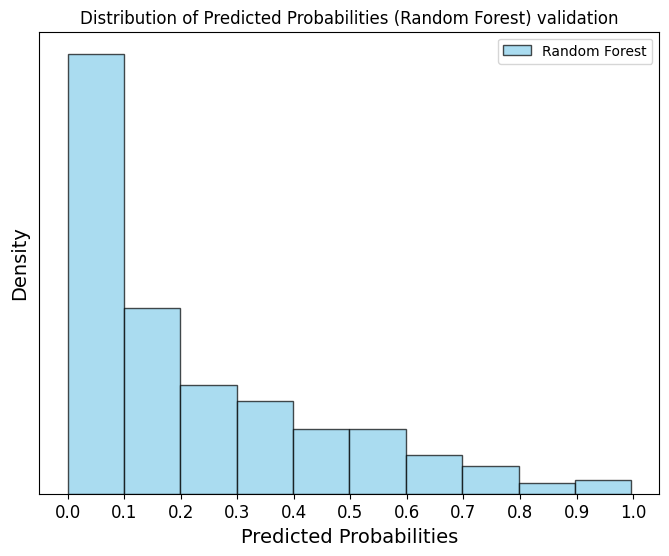

In [45]:
# Plotting a histogram to see how the probabilities are distributed in the case of Random Forest (validation data) to better understand what kind of predictions the model makes


import matplotlib.pyplot as plt
import numpy as np


num_bins = 10  # You can adjust the number of bins
plt.figure(figsize=(8, 6))  # Set the figure size

plt.hist(goal_probabilities_rf_val, bins=num_bins, density=True, color='skyblue', alpha=0.7, edgecolor='black')

# Add labels and a title
plt.xlabel('Predicted Probabilities')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities (Random Forest) validation')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks([])  # Hide y-axis tick marks

plt.legend(['Random Forest'], loc='upper right')

#plt.savefig('RF_prob_density.png')
plt.show()